In [ ]:
# ============================================
# CIS-583 Final Term Project
# Simple DCRNN on PEMS-BAY (multi-sensor)
# ============================================

# 1. Mount Drive and imports
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using device: cuda


In [ ]:
# 2. File path and basic hyperparameters

PEMS_BAY_FILE = "/content/drive/MyDrive/CIS-583 Deep Learning/CIS-583 Deep Learning: The Fourcast Quarter/Assets/Datasets/PEMS-BAY/pems-bay.h5"

# We'll keep sequence settings simple
SEQ_LEN   = 12   # how many past steps (1 hour)
PRED_LEN  = 12    # 1-step ahead prediction

# Split ratios over time
TRAIN_RATIO = 0.7
VAL_RATIO   = 0.1  # test gets remaining 0.2

# To keep memory manageable, we use only the first 5000 timesteps (like your original DCRNN code)
MAX_TIMESTEPS = 5000

# Training hyperparameters
BATCH_SIZE  = 32
HIDDEN_DIM  = 64
LR          = 1e-3
EPOCHS      = 10

In [ ]:
# 3. Load and inspect PEMS-BAY from H5 (same style as LSTM)

print("Loading PEMS-BAY from H5...")

with h5py.File(PEMS_BAY_FILE, "r") as f:
    # main data array → shape (time_steps, num_sensors)
    data_np = np.array(f["speed/block0_values"])      # e.g., (52116, 325)
    idx_np  = np.array(f["speed/axis0"])              # sensor IDs (325)
    cols_np = np.array(f["speed/axis1"])              # timestamps (52116)

print("Raw PEMS-BAY shape:", data_np.shape)
# Expected: (52116, 325)

# Convert bytes → strings if needed
if np.issubdtype(idx_np.dtype, np.bytes_):
    idx_np = idx_np.astype("U32")
if np.issubdtype(cols_np.dtype, np.bytes_):
    cols_np = cols_np.astype("U32")

# Parse timestamps
try:
    timestamps = pd.to_datetime(cols_np)
except Exception:
    timestamps = pd.date_range(start="2017-01-01", periods=data_np.shape[0], freq="5min")

sensor_ids = [str(x) for x in idx_np]

# Build DataFrame (like LSTM notebook)
df = pd.DataFrame(data_np, index=timestamps, columns=sensor_ids).astype(np.float32)

print(df.head())
print("DataFrame shape:", df.shape)
print("Num sensors:", len(df.columns))
print("Num time steps:", len(df))

Loading PEMS-BAY from H5...
Raw PEMS-BAY shape: (52116, 325)
                        400001     400017     400030     400040     400045  \
2017-01-01 00:00:00  71.400002  67.800003  70.500000  67.400002  68.800003   
2017-01-01 00:05:00  71.599998  67.500000  70.599998  67.500000  68.699997   
2017-01-01 00:10:00  71.599998  67.599998  70.199997  67.400002  68.699997   
2017-01-01 00:15:00  71.099998  67.500000  70.300003  68.000000  68.500000   
2017-01-01 00:20:00  71.699997  67.800003  70.199997  68.099998  68.400002   

                        400052     400057     400059     400065     400069  \
2017-01-01 00:00:00  66.599998  66.800003  68.000000  66.800003  69.000000   
2017-01-01 00:05:00  66.599998  66.800003  67.800003  66.500000  68.199997   
2017-01-01 00:10:00  66.099998  66.800003  67.800003  66.199997  67.800003   
2017-01-01 00:15:00  66.699997  66.599998  67.699997  65.900002  67.800003   
2017-01-01 00:20:00  66.900002  66.099998  67.699997  66.099998  67.800003   

 

In [ ]:
# 4. Truncate to first MAX_TIMESTEPS and create train/val/test splits

# Use only first MAX_TIMESTEPS rows for memory reasons
T_total = min(MAX_TIMESTEPS, df.shape[0])
df_small = df.iloc[:T_total]

print("Using timesteps:", T_total)

# Convert to numpy: [T, N]
data_all = df_small.values.astype(np.float32)
T, N = data_all.shape
print("data_all shape (T, N):", data_all.shape)

# Split along time dimension
num_train = int(T * TRAIN_RATIO)
num_val   = int(T * VAL_RATIO)
num_test  = T - num_train - num_val

train_raw = data_all[:num_train]                           # [T_train, N]
val_raw   = data_all[num_train:num_train + num_val]        # [T_val, N]
test_raw  = data_all[num_train + num_val:]                 # [T_test, N]

print("Train len:", len(train_raw))
print("Val len:", len(val_raw))
print("Test len:", len(test_raw))

Using timesteps: 5000
data_all shape (T, N): (5000, 325)
Train len: 3500
Val len: 500
Test len: 1000


In [ ]:
# 5. Normalize using train stats (per sensor)

train_mean = train_raw.mean(axis=0)  # [N]
train_std  = train_raw.std(axis=0)   # [N]

def normalize(mat):
    # mat: [T_split, N]
    return (mat - train_mean) / (train_std + 1e-8)

def denormalize(mat):
    # mat: same shape as mat_norm (broadcast)
    return mat * (train_std + 1e-8) + train_mean

train_norm = normalize(train_raw)
val_norm   = normalize(val_raw)
test_norm  = normalize(test_raw)

print("Train mean (first 5):", train_mean[:5])
print("Train std  (first 5):", train_std[:5])

Train mean (first 5): [67.44325  59.51208  59.66846  60.4765   58.306026]
Train std  (first 5): [ 7.34233  12.562707 10.729334  9.915631  8.244434]


In [ ]:
# 6. Create sequences for DCRNN: (X, Y) with shape [num_windows, seq_len, num_nodes, 1]

def create_sequences(data_2d, seq_len=12, pred_len=1):
    """
    data_2d: numpy array [T, N]
    We add a fake 'sample' axis so it matches [num_samples, timesteps, num_nodes].
    Returns:
        X: [num_windows, seq_len, num_nodes, 1]
        Y: [num_windows, pred_len, num_nodes, 1]
    """
    # Add sample dimension → [1, T, N]
    data = data_2d[np.newaxis, :, :]
    num_samples, timesteps, num_nodes = data.shape  # num_samples=1

    # Reorder to (T, num_samples, num_nodes) = (T, 1, N)
    data = np.transpose(data, (1, 0, 2))

    X_list, Y_list = [], []
    # same logic as your previous DCRNN code, but made a little clearer
    for i in range(timesteps - seq_len - pred_len + 1):
        X_list.append(data[i:i+seq_len, :, :])                 # [seq_len, 1, N]
        Y_list.append(data[i+seq_len:i+seq_len+pred_len, :, :])# [pred_len, 1, N]

    X = np.stack(X_list, axis=0)  # [num_windows, seq_len, 1, N]
    Y = np.stack(Y_list, axis=0)  # [num_windows, pred_len, 1, N]

    # reshape to (num_windows * num_samples, seq_len, num_nodes, 1)
    X = X.reshape(-1, seq_len, num_nodes, 1)
    Y = Y.reshape(-1, pred_len, num_nodes, 1)
    return X, Y

SEQ_LEN = 12
PRED_LEN = 1  # 1-step prediction

X_train, Y_train = create_sequences(train_norm, SEQ_LEN, PRED_LEN)
X_val,   Y_val   = create_sequences(val_norm,   SEQ_LEN, PRED_LEN)
X_test,  Y_test  = create_sequences(test_norm,  SEQ_LEN, PRED_LEN)

print("X_train shape:", X_train.shape)  # [num_train_windows, 12, N, 1]
print("Y_train shape:", Y_train.shape)  # [num_train_windows, 1,  N, 1]
print("X_val shape:", X_val.shape)
print("X_test shape:", X_test.shape)

X_train shape: (3488, 12, 325, 1)
Y_train shape: (3488, 1, 325, 1)
X_val shape: (488, 12, 325, 1)
X_test shape: (988, 12, 325, 1)


In [ ]:
# 7. DataLoaders

def to_dataloader(X, Y, batch_size=32, shuffle=True):
    X_tensor = torch.FloatTensor(X)
    Y_tensor = torch.FloatTensor(Y)
    dataset = TensorDataset(X_tensor, Y_tensor)
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

train_loader = to_dataloader(X_train, Y_train, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = to_dataloader(X_val,   Y_val,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = to_dataloader(X_test,  Y_test,  batch_size=BATCH_SIZE, shuffle=False)

print("Train batches:", len(train_loader))
print("Val batches:", len(val_loader))
print("Test batches:", len(test_loader))

Train batches: 109
Val batches: 16
Test batches: 31


In [ ]:
# 8. Simple DCRNN components (same structure, just cleaned up)

class DiffusionConv(nn.Module):
    def __init__(self, num_nodes, input_dim, output_dim):
        super().__init__()
        self.theta = nn.Parameter(torch.FloatTensor(input_dim, output_dim))
        nn.init.xavier_uniform_(self.theta)

    def forward(self, x, adj):
        """
        x:   [B, N, F]
        adj: [N, N]
        returns: [B, N, output_dim]
        """
        # simple one-step diffusion: A * X * theta
        # first: A * X → [B, N, F]
        diffused = torch.einsum("ij,bjf->bif", adj, x)
        # then: (A * X) * theta → [B, N, output_dim]
        out = torch.einsum("bif,fo->bio", diffused, self.theta)
        return out


class DCRNNCell(nn.Module):
    def __init__(self, num_nodes, input_dim, hidden_dim):
        super().__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim
        # input to cell is [X_t, h_{t-1}] along feature dimension
        self.diff_conv = DiffusionConv(num_nodes, input_dim + hidden_dim, hidden_dim)
        self.update_gate = nn.GRUCell(hidden_dim, hidden_dim)

    def forward(self, x_t, h_prev, adj):
        """
        x_t:    [B, N, input_dim]
        h_prev: [B, N, hidden_dim]
        adj:    [N, N]
        """
        combined = torch.cat([x_t, h_prev], dim=-1)   # [B, N, input_dim+hidden_dim]
        conv_out = self.diff_conv(combined, adj)      # [B, N, hidden_dim]

        # GRUCell expects [B*N, hidden_dim]
        B, N, H = conv_out.shape
        conv_flat = conv_out.reshape(B * N, H)
        h_prev_flat = h_prev.reshape(B * N, H)

        h_new_flat = self.update_gate(conv_flat, h_prev_flat)
        h_new = h_new_flat.view(B, N, H)
        return h_new


class DCRNN(nn.Module):
    def __init__(self, num_nodes, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.num_nodes = num_nodes
        self.hidden_dim = hidden_dim

        self.cell = DCRNNCell(num_nodes, input_dim, hidden_dim)
        self.fc   = nn.Linear(hidden_dim, output_dim)

        # Learnable adjacency (very simplified)
        self.adj = nn.Parameter(torch.eye(num_nodes), requires_grad=True)

    def forward(self, x):
        """
        x: [B, seq_len, N, input_dim]
        We roll over time with DCRNNCell and return 1-step ahead:
           output shape: [B, 1, N, output_dim]
        """
        B, T, N, F = x.shape
        h = torch.zeros(B, N, self.hidden_dim, device=x.device)
        for t in range(T):
            x_t = x[:, t, :, :]         # [B, N, F]
            h = self.cell(x_t, h, self.adj)

        # map hidden state to output_dim
        out = self.fc(h)                # [B, N, output_dim]
        return out.unsqueeze(1)         # [B, 1, N, output_dim]

In [ ]:
# 9. Initialize model, loss, optimizer

num_nodes  = X_train.shape[2]
input_dim  = 1
hidden_dim = HIDDEN_DIM
output_dim = 1

model = DCRNN(num_nodes, input_dim, hidden_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=LR)
criterion = nn.MSELoss()

print(model)
print("Num nodes:", num_nodes)

DCRNN(
  (cell): DCRNNCell(
    (diff_conv): DiffusionConv()
    (update_gate): GRUCell(64, 64)
  )
  (fc): Linear(in_features=64, out_features=1, bias=True)
)
Num nodes: 325


In [ ]:
# 10. Training loop (very similar style to LSTM)

def evaluate_mse(loader):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for X_batch, Y_batch in loader:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            preds = model(X_batch)             # [B, 1, N, 1]
            loss = criterion(preds, Y_batch)   # compare full 1-step target
            total_loss += loss.item() * X_batch.size(0)
    return total_loss / len(loader.dataset)

best_val_mse = float("inf")

for epoch in range(1, EPOCHS + 1):
    model.train()
    total_train_loss = 0.0

    for X_batch, Y_batch in train_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        optimizer.zero_grad()
        preds = model(X_batch)
        loss = criterion(preds, Y_batch)
        loss.backward()
        optimizer.step()

        total_train_loss += loss.item() * X_batch.size(0)

    train_mse = total_train_loss / len(train_loader.dataset)
    val_mse   = evaluate_mse(val_loader)

    if val_mse < best_val_mse:
        best_val_mse = val_mse
        torch.save(model.state_dict(), "/content/dcrnn_pemsbay_best.pt")

    print(f"Epoch {epoch:02d} | Train MSE (norm): {train_mse:.6f} | Val MSE (norm): {val_mse:.6f}")

print("Best Val MSE (normalized):", best_val_mse)

Epoch 01 | Train MSE (norm): 0.154294 | Val MSE (norm): 0.050123
Epoch 02 | Train MSE (norm): 0.045097 | Val MSE (norm): 0.038908
Epoch 03 | Train MSE (norm): 0.039047 | Val MSE (norm): 0.037198
Epoch 04 | Train MSE (norm): 0.037153 | Val MSE (norm): 0.037253
Epoch 05 | Train MSE (norm): 0.035934 | Val MSE (norm): 0.036332
Epoch 06 | Train MSE (norm): 0.035213 | Val MSE (norm): 0.036770
Epoch 07 | Train MSE (norm): 0.034571 | Val MSE (norm): 0.036298
Epoch 08 | Train MSE (norm): 0.033991 | Val MSE (norm): 0.037105
Epoch 09 | Train MSE (norm): 0.033757 | Val MSE (norm): 0.036935
Epoch 10 | Train MSE (norm): 0.033132 | Val MSE (norm): 0.038063
Best Val MSE (normalized): 0.036298011689156785


In [ ]:
# 11. Test metrics: MSE + MAE/RMSE in original units (1-step ahead)

from math import sqrt

model.load_state_dict(torch.load("/content/dcrnn_pemsbay_best.pt", map_location=device))
model.eval()

# 1) normalized MSE on test set
test_mse_norm = evaluate_mse(test_loader)
print("Test MSE (normalized):", test_mse_norm)

# 2) MAE and RMSE in original speed units
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        preds = model(X_batch)         # [B, 1, N, 1]
        preds = preds.cpu().numpy()
        targets = Y_batch.cpu().numpy()

        # remove time+feature dim → [B, N]
        preds = preds.squeeze(1).squeeze(-1)
        targets = targets.squeeze(1).squeeze(-1)

        all_preds.append(preds.reshape(-1, N))     # flatten batch, keep N
        all_targets.append(targets.reshape(-1, N))

all_preds = np.concatenate(all_preds, axis=0)      # [num_total_steps, N]
all_targets = np.concatenate(all_targets, axis=0)  # [num_total_steps, N]

# denormalize
all_preds_denorm   = denormalize(all_preds)
all_targets_denorm = denormalize(all_targets)

mae = np.mean(np.abs(all_preds_denorm - all_targets_denorm))
rmse = sqrt(np.mean((all_preds_denorm - all_targets_denorm) ** 2))

print(f"Test MAE (original units):  {mae:.4f}")
print(f"Test RMSE (original units): {rmse:.4f}")

Test MSE (normalized): 0.03665909949343214
Test MAE (original units):  0.8007
Test RMSE (original units): 1.3719


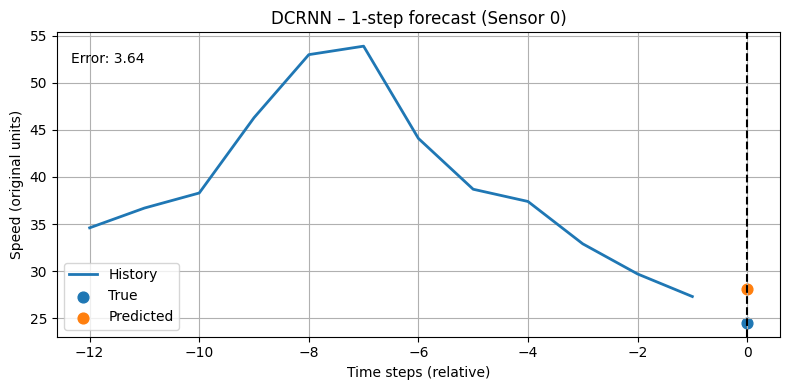

In [ ]:
# 13. Visualize one forecast vs ground truth for a chosen sensor

sensor_index = 0   # you can change this

# Use last test window
example_idx = X_test.shape[0] - 1
X_example = X_test[example_idx:example_idx+1]  # [1, seq_len, N, 1]
Y_example = Y_test[example_idx:example_idx+1]  # [1, 1,      N, 1]

model.eval()
with torch.no_grad():
    X_torch = torch.from_numpy(X_example).float().to(device)
    pred_full = model(X_torch).cpu().numpy()   # [1, 1, N, 1]

# Extract normalized history + future
history_norm     = X_example[0, :, sensor_index, 0]  # [seq_len]
true_future_norm = Y_example[0, 0, sensor_index, 0]  # scalar
pred_future_norm = pred_full[0, 0, sensor_index, 0]  # scalar

# Per-sensor stats
mean = float(train_mean[sensor_index])
std  = float(train_std[sensor_index])

# Denormalize
history     = history_norm * (std + 1e-8) + mean
true_future = true_future_norm * (std + 1e-8) + mean
pred_future = pred_future_norm * (std + 1e-8) + mean

# x-axis
hist_x = list(range(-len(history), 0))
future_x = [0]

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(hist_x, history, label="History", linewidth=2)
ax.scatter(future_x, [true_future], label="True", s=60)
ax.scatter(future_x, [pred_future], label="Predicted", s=60)

ax.axvline(0, color="k", linestyle="--")
ax.set_xlabel("Time steps (relative)")
ax.set_ylabel("Speed (original units)")
ax.set_title(f"DCRNN – 1-step forecast (Sensor {sensor_index})")
ax.grid(True)

err = float(abs(true_future - pred_future))
ax.text(0.02, 0.9, f"Error: {err:.2f}", transform=ax.transAxes)

ax.legend()
plt.tight_layout()
plt.show()

Best sensors: [177  74 117]
Worst sensors: [133 292 146]
Random sensors: [267 299  76]


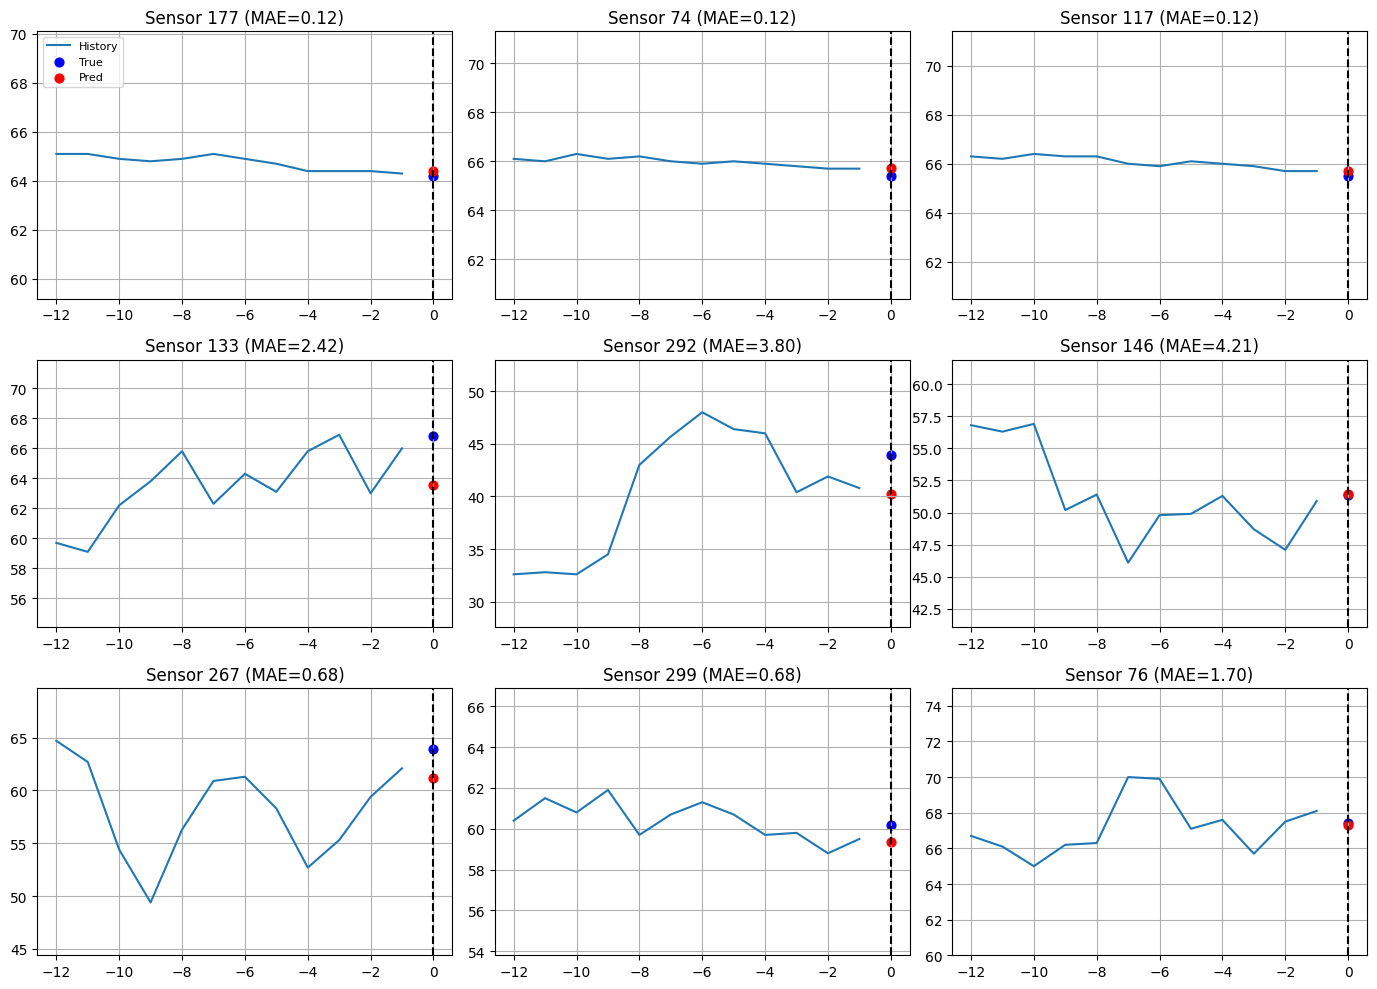

In [ ]:
# 14. DCRNN – 3×3 grid: best, worst, and random sensors
# -----------------------------------------------------

import math

# pick 3 best, 3 worst, 3 random
N_sensors = mae_per_sensor.shape[0]

best_3   = np.argsort(mae_per_sensor)[:3]
worst_3  = np.argsort(mae_per_sensor)[-3:]
random_3 = np.random.choice(N_sensors, 3, replace=False)

sensor_indices = list(best_3) + list(worst_3) + list(random_3)
print("Best sensors:", best_3)
print("Worst sensors:", worst_3)
print("Random sensors:", random_3)

cols = 3
rows = 3

# Use last test window
example_idx = X_test.shape[0] - 1
X_example = X_test[example_idx:example_idx+1]  # [1, seq_len, N, 1]
Y_example = Y_test[example_idx:example_idx+1]  # [1, 1,      N, 1]

model.eval()
with torch.no_grad():
    X_torch = torch.from_numpy(X_example).float().to(device)
    pred_full = model(X_torch).cpu().numpy()   # [1, 1, N, 1]

plt.figure(figsize=(14, 10))

for i, sensor_index in enumerate(sensor_indices):
    history_norm     = X_example[0, :, sensor_index, 0]
    true_future_norm = Y_example[0, 0, sensor_index, 0]
    pred_future_norm = pred_full[0, 0, sensor_index, 0]

    mean = float(train_mean[sensor_index])
    std  = float(train_std[sensor_index])

    history     = history_norm * (std + 1e-8) + mean
    true_future = true_future_norm * (std + 1e-8) + mean
    pred_future = pred_future_norm * (std + 1e-8) + mean

    hist_x   = list(range(-len(history), 0))
    future_x = [0]

    ax = plt.subplot(rows, cols, i + 1)
    ax.plot(hist_x, history, label="History", linewidth=1.5)
    ax.scatter(future_x, [true_future], s=40, label="True", color="blue")
    ax.scatter(future_x, [pred_future], s=40, label="Pred", color="red")

    ax.axvline(0, color="k", linestyle="--")
    ax.set_title(f"Sensor {sensor_index} (MAE={mae_per_sensor[sensor_index]:.2f})")
    ax.grid(True)

    # unify y-limits a bit locally for each plot
    ymin = min(history.min(), true_future, pred_future) - 5
    ymax = max(history.max(), true_future, pred_future) + 5
    ax.set_ylim([ymin, ymax])

    if i == 0:
        ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

mae_per_sensor shape: (325,)


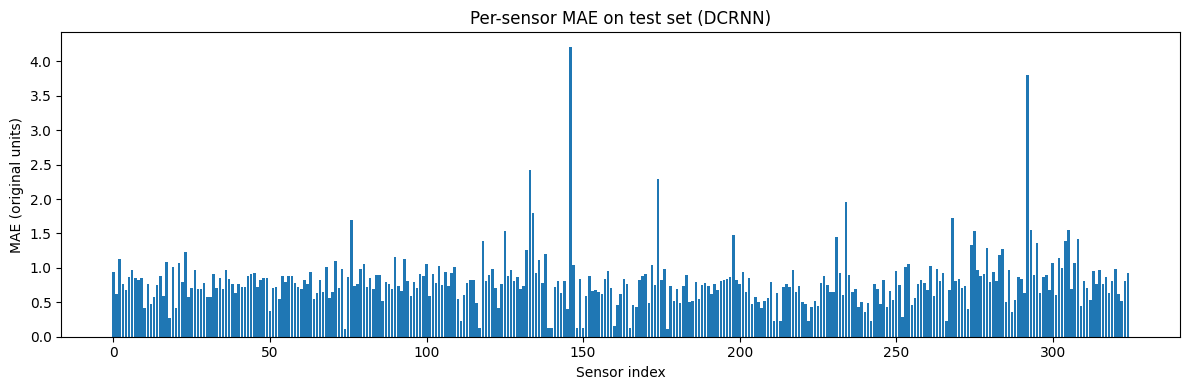

In [ ]:
# 15. Per-sensor MAE bar plot
# Quickly show which sensors are hardest to predict (higher bar = worse MAE).

model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for X_batch, Y_batch in test_loader:
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)

        preds = model(X_batch)          # [B, 1, N, 1]
        preds = preds.cpu().numpy()
        targets = Y_batch.cpu().numpy()

        # remove time + feature dims → [B, N]
        preds = preds.squeeze(1).squeeze(-1)
        targets = targets.squeeze(1).squeeze(-1)

        all_preds.append(preds)
        all_targets.append(targets)

# Stack over batches → [T_flat, N]
all_preds = np.concatenate(all_preds, axis=0)      # normalized
all_targets = np.concatenate(all_targets, axis=0)  # normalized

# Denormalize to original units
all_preds_denorm   = denormalize(all_preds)
all_targets_denorm = denormalize(all_targets)

# Absolute error: [T_flat, N]
abs_errors = np.abs(all_preds_denorm - all_targets_denorm)

# Per-sensor MAE: [N]
mae_per_sensor = abs_errors.mean(axis=0)

print("mae_per_sensor shape:", mae_per_sensor.shape)

plt.figure(figsize=(12, 4))
plt.bar(np.arange(len(mae_per_sensor)), mae_per_sensor)
plt.xlabel("Sensor index")
plt.ylabel("MAE (original units)")
plt.title("Per-sensor MAE on test set (DCRNN)")
plt.tight_layout()
plt.show()